# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = '../data/'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ../data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

In [3]:
# 將資料型態獨立出來檢視
t = app_train.dtypes.reset_index()
t

,index,0
0,SK_ID_CURR,int64
1,TARGET,int64
2,NAME_CONTRACT_TYPE,object
3,CODE_GENDER,object
4,FLAG_OWN_CAR,object
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,float64
118,AMT_REQ_CREDIT_BUREAU_WEEK,float64
119,AMT_REQ_CREDIT_BUREAU_MON,float64
120,AMT_REQ_CREDIT_BUREAU_QRT,float64


In [4]:
# 將可能有outlier的資料型態(我選 int64 及 float64 )轉換為Ture, 其他則轉為False以利後續處理
t[0] = t[0].apply(lambda x:True if x == 'int64' or x =='float64' else False)
t


,index,0
0,SK_ID_CURR,True
1,TARGET,True
2,NAME_CONTRACT_TYPE,False
3,CODE_GENDER,False
4,FLAG_OWN_CAR,False
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,True
118,AMT_REQ_CREDIT_BUREAU_WEEK,True
119,AMT_REQ_CREDIT_BUREAU_MON,True
120,AMT_REQ_CREDIT_BUREAU_QRT,True


In [5]:
#篩選想觀察的欄位
app_train = app_train[app_train.columns[t[0] == True]]
app_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:


# 欄位名稱另用變數儲存備用
col = app_train.columns

# 移除二元分類的欄位
for i in col:
    if len(app_train[i].unique()) == 2:
        app_train = app_train.drop(i, axis=1)
    

app_train

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,0.0,6.0,0.0,-1909.0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 更新col, index
col = app_train.columns
index = pd.Series(app_train.reset_index()['index'])
index

0              0
1              1
2              2
3              3
4              4
           ...  
307506    307506
307507    307507
307508    307508
307509    307509
307510    307510
Name: index, Length: 307511, dtype: int64

In [8]:
# 觀察一下各欄位資料
for i in col:
    print(app_train[i].describe())

count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75

count    153161.000000
mean          0.105975
std           0.111845
min           0.000000
25%           0.042700
50%           0.073100
75%           0.125200
max           1.000000
Name: LIVINGAREA_MODE, dtype: float64
count    93997.000000
mean         0.008076
std          0.046276
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003900
max          1.000000
Name: NONLIVINGAPARTMENTS_MODE, dtype: float64
count    137829.000000
mean          0.027022
std           0.070254
min           0.000000
25%           0.000000
50%           0.001100
75%           0.023100
max           1.000000
Name: NONLIVINGAREA_MODE, dtype: float64
count    151450.000000
mean          0.117850
std           0.109076
min           0.000000
25%           0.058300
50%           0.086400
75%           0.148900
max           1.000000
Name: APARTMENTS_MEDI, dtype: float64
count    127568.000000
mean          0.087955
std           0.082179
min           0.000000
25%           0.

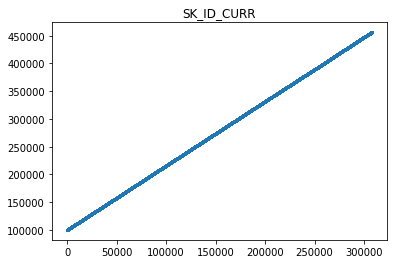

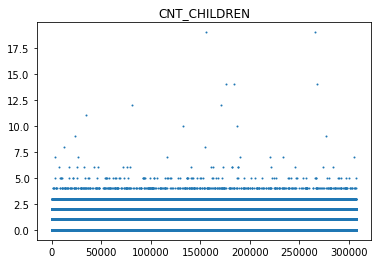

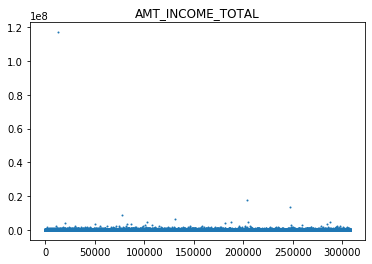

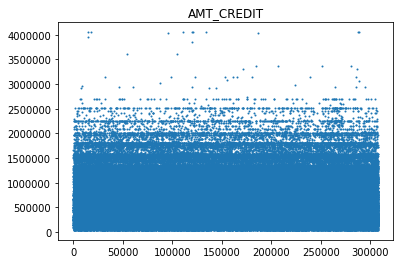

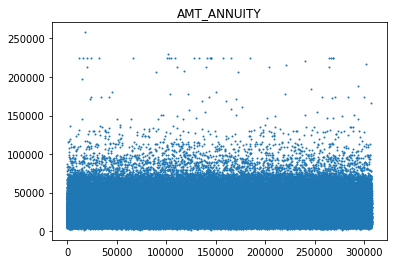

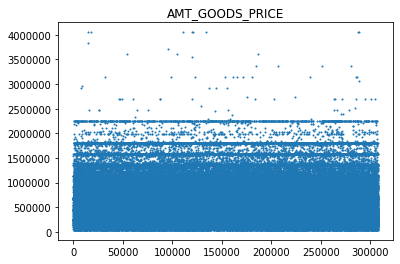

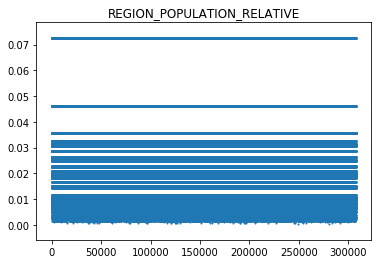

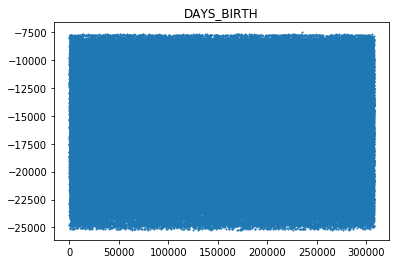

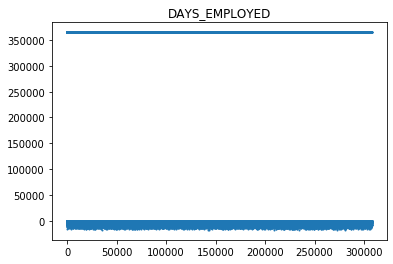

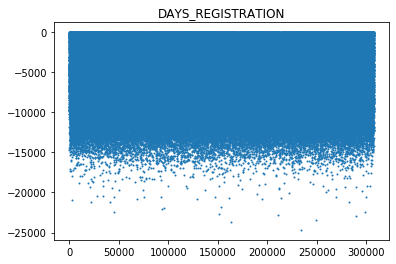

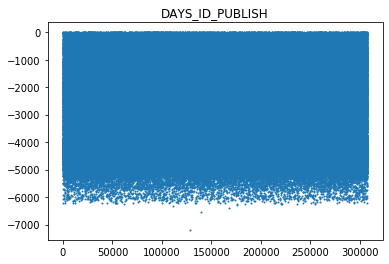

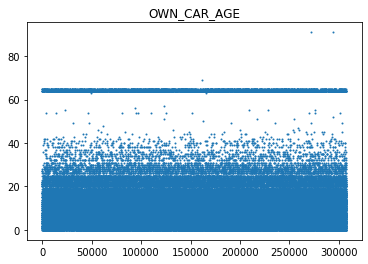

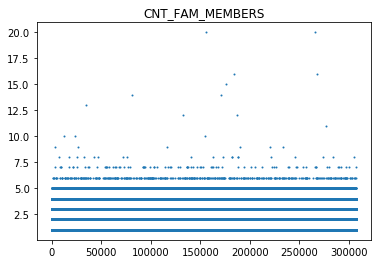

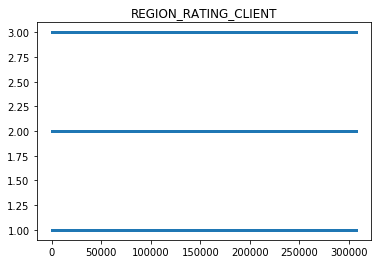

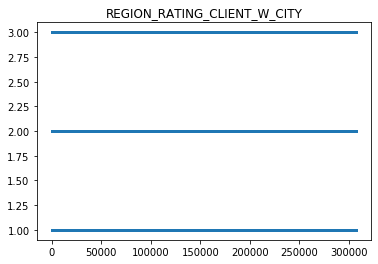

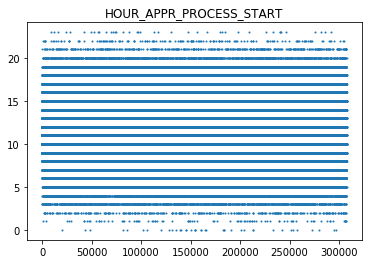

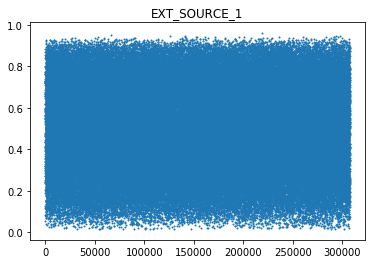

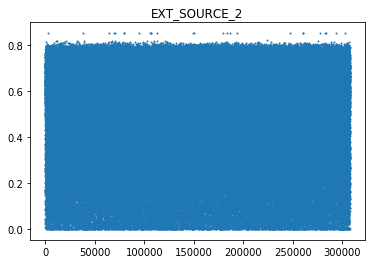

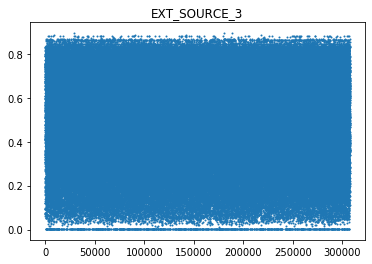

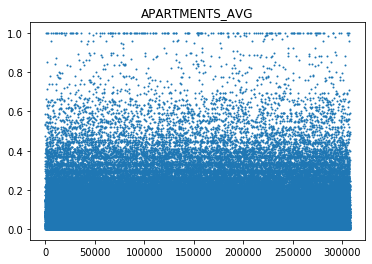

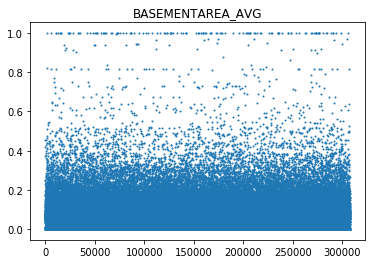

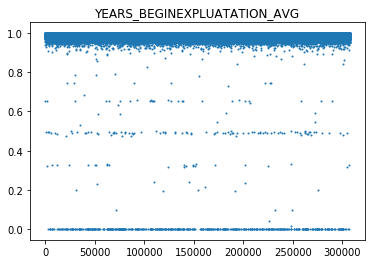

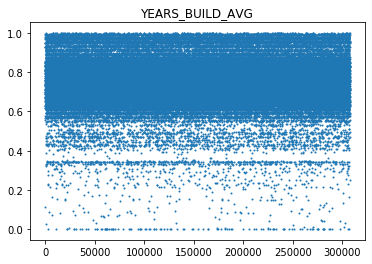

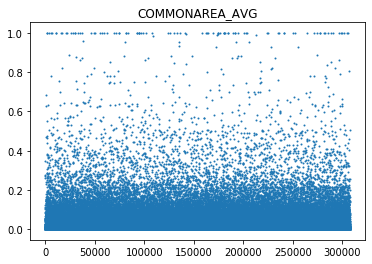

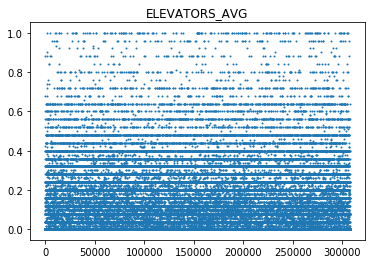

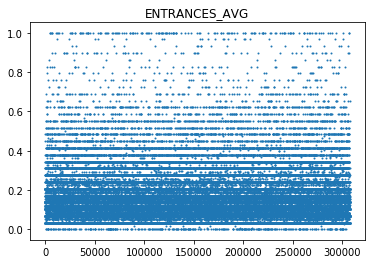

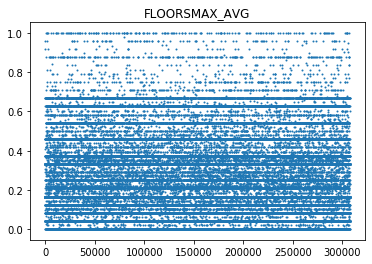

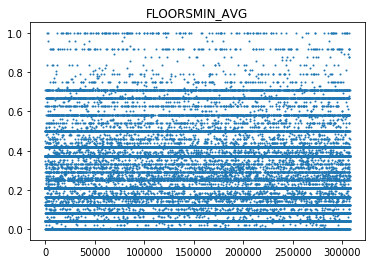

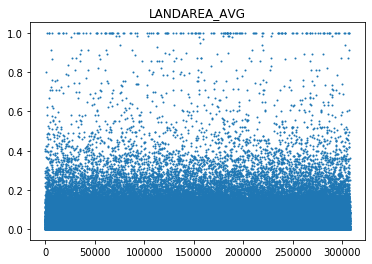

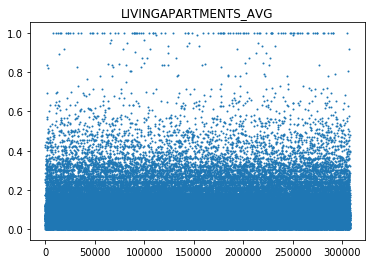

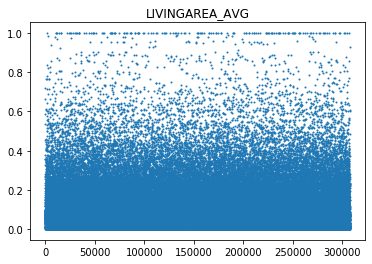

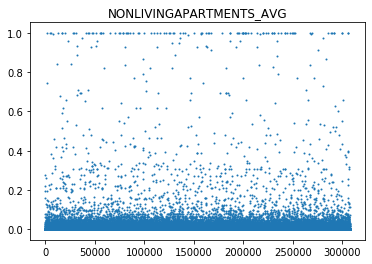

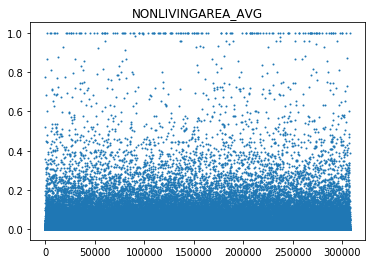

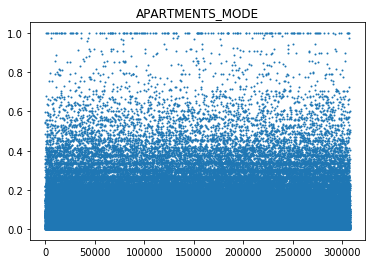

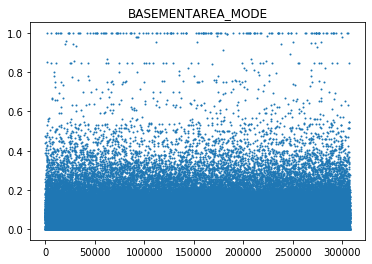

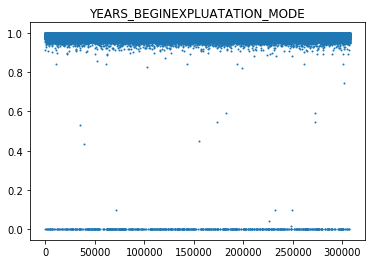

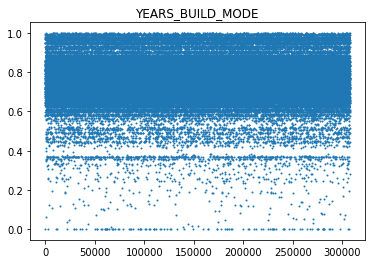

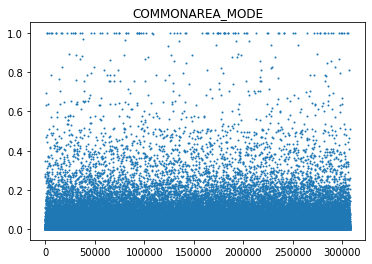

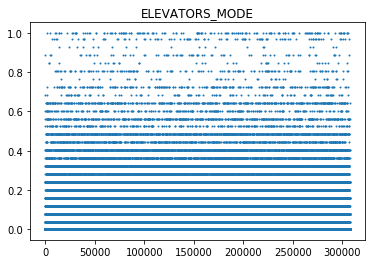

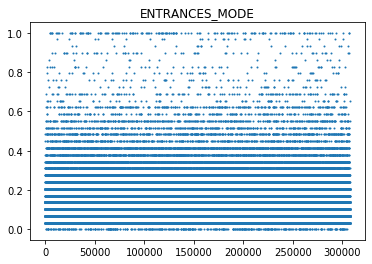

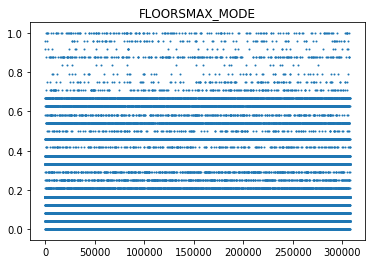

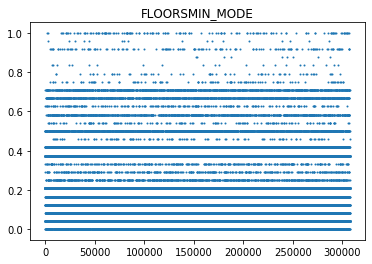

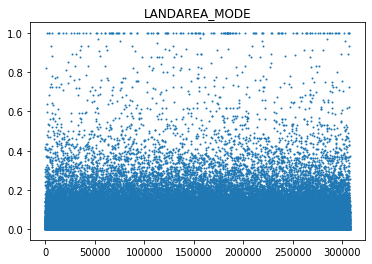

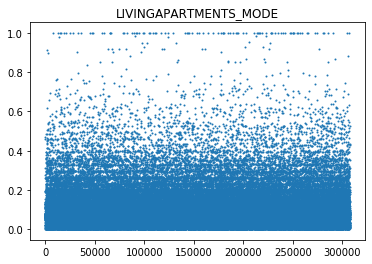

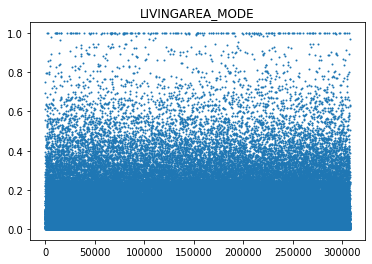

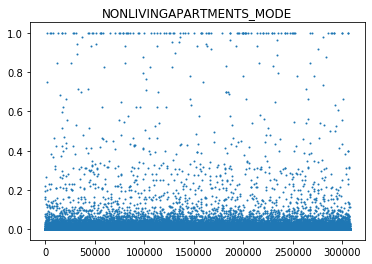

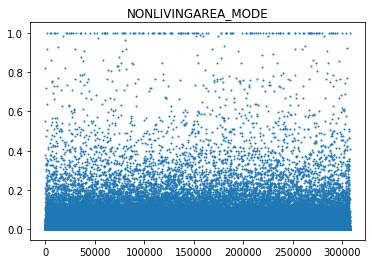

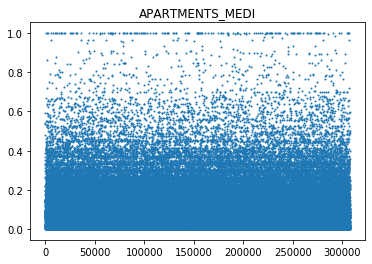

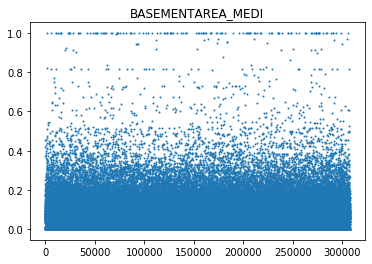

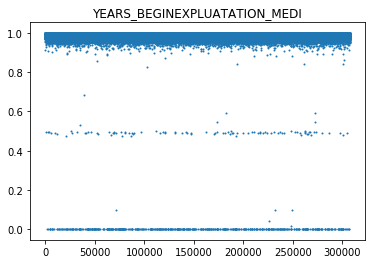

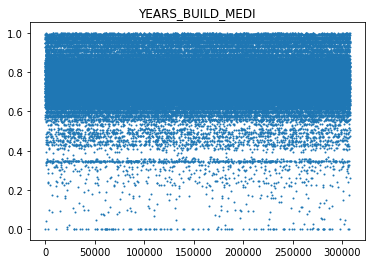

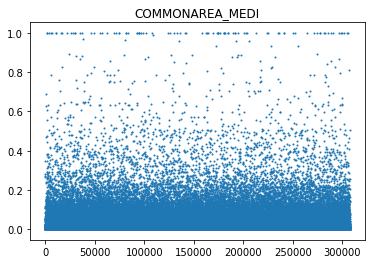

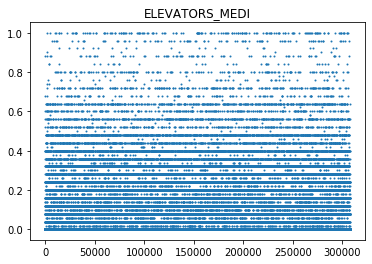

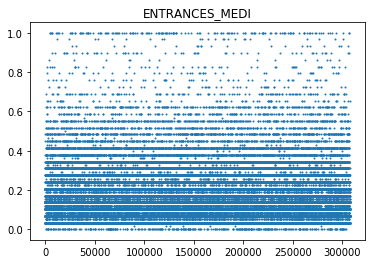

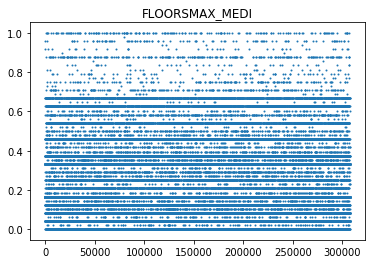

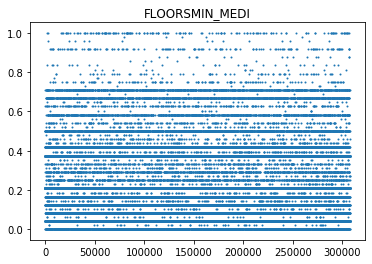

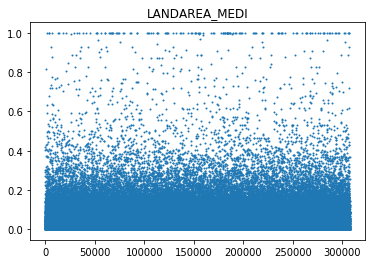

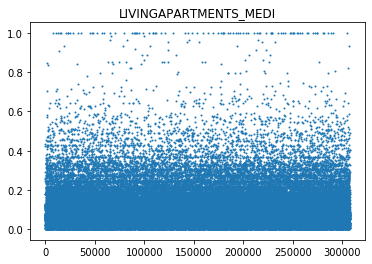

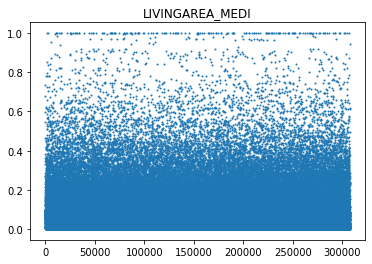

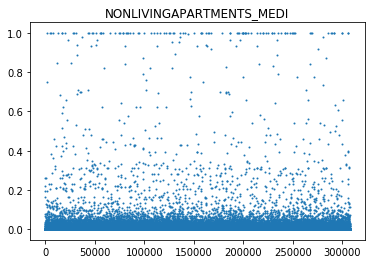

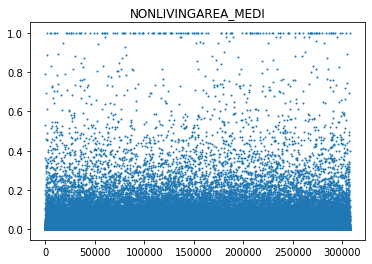

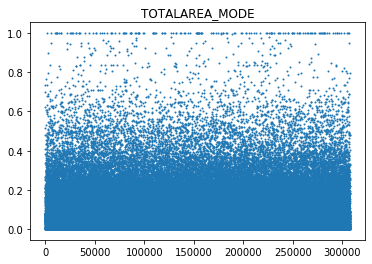

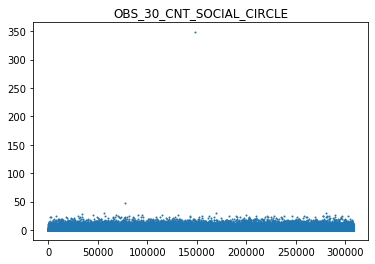

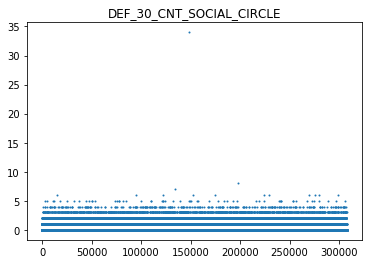

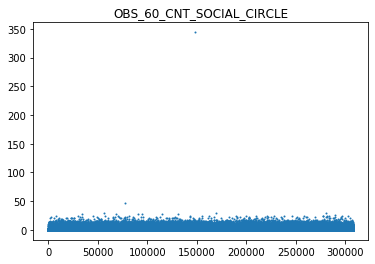

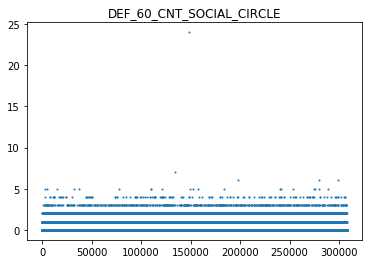

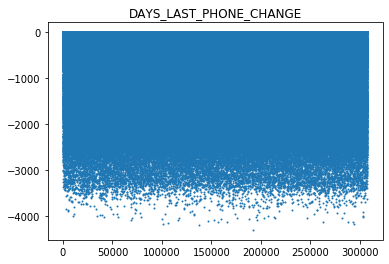

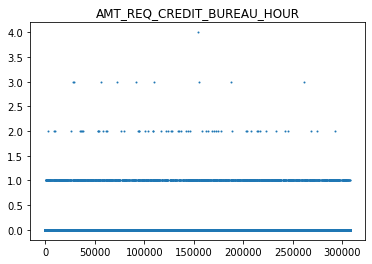

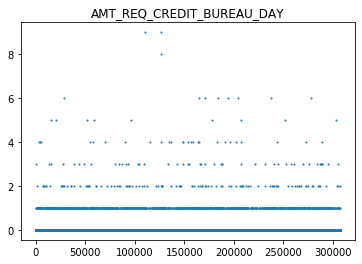

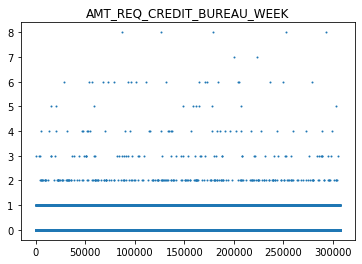

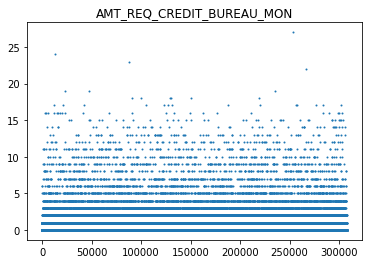

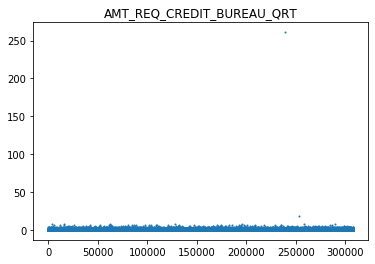

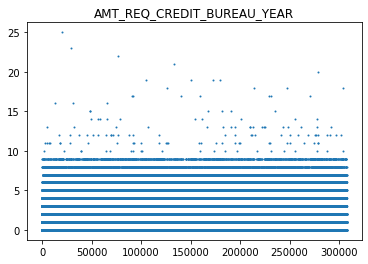

In [9]:
# 檢視這些欄位的數值範圍
# 利用散布圖觀察資料分布情況
for l in col.tolist():
    plt.title(l)
    plt.scatter(index,app_train[l], s=1)
    plt.show()


In [14]:
app_train[app_train['CNT_FAM_MEMBERS']>15]['CNT_FAM_MEMBERS'].count()

4

In [ ]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# CNT_FAM_MEMBERS
# OBS_60_CNT_SOCIAL_CIRCLE

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


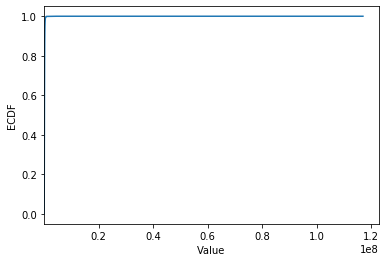

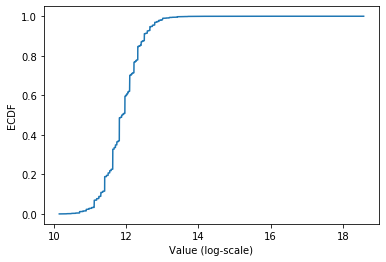

In [15]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
YOUR CODE HERE
"""
cdf = app_train['AMT_INCOME_TOTAL'].value_counts().sort_index().cumsum()


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


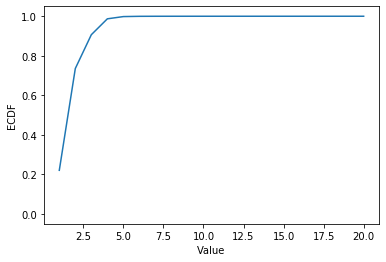

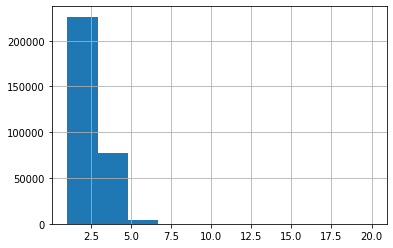

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
16.0         2
12.0         2
20.0         2
11.0         1
13.0         1
15.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [16]:
# 最大值落在分布之外
print(app_train['CNT_FAM_MEMBERS'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here
"""
cdf = app_train['CNT_FAM_MEMBERS'].value_counts().sort_index().cumsum()


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['CNT_FAM_MEMBERS'].hist()
plt.show()

app_train['CNT_FAM_MEMBERS'].value_counts()

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


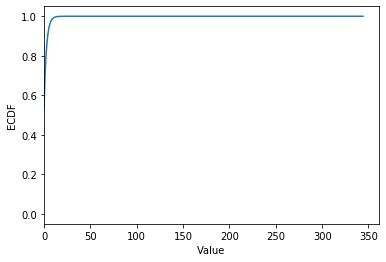

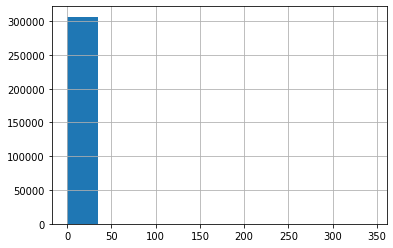

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [17]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
'''
Your Code Here
'''
cdf = app_train.OBS_60_CNT_SOCIAL_CIRCLE.value_counts().sort_index().cumsum()


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值